In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Merge these two dataframes along the stay_id column.
df=pd.read_csv('train.csv')


In [5]:
#First look at the data.
df.describe()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,day_of_week_intime,stay_length_hours,pain_cleaned,pain_cleaned_advanced
count,3.702000e+05,3.702000e+05,349374.000000,355042.000000,352180.000000,351956.000000,353923.000000,353327.000000,364017.000000,370200.000000,370200.000000,335572.000000,346379.000000
mean,1.500807e+07,3.499598e+07,98.087303,85.053128,17.562076,98.371309,134.986818,81.435715,2.616501,2.999071,7.245178,4.148449,4.319138
std,2.879698e+06,2.888004e+06,0.977550,18.104575,2.542687,2.467737,22.728856,1129.537497,0.709251,2.002601,6.578481,3.749624,3.819368
min,1.000003e+07,3.000001e+07,82.400000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000
25%,1.251546e+07,3.249741e+07,97.600000,72.000000,16.000000,97.000000,120.000000,68.000000,2.000000,1.000000,3.608056,0.000000,0.000000
50%,1.501261e+07,3.499177e+07,98.000000,84.000000,18.000000,99.000000,133.000000,77.000000,3.000000,3.000000,5.533333,4.000000,5.000000
75%,1.750291e+07,3.750343e+07,98.600000,96.000000,18.000000,100.000000,148.000000,87.000000,3.000000,5.000000,8.398958,8.000000,8.000000
max,1.999999e+07,3.999996e+07,110.000000,1228.000000,209.000000,100.000000,960.000000,661672.000000,5.000000,6.000000,192.566667,10.000000,10.000000


In [6]:
#Check how many missing values there are for each variable. 
df.isna().sum()

subject_id                   0
stay_id                      0
intime                       0
outtime                      0
gender                       0
race                         0
arrival_transport            0
temperature              20826
heartrate                15158
resprate                 18020
o2sat                    18244
sbp                      16277
dbp                      16873
pain                     11419
acuity                    6183
chiefcomplaint              15
day_of_week_intime           0
time_of_day_intime           0
stay_length_hours            0
pain_cleaned             34628
pain_cleaned_advanced    23821
race_condensed            8090
dtype: int64

In [7]:
#Investigate this more by checking how these missing values are distributed. The following compute the number of missing values 
# in each row and then looks at the distribution of this count. It appears that for all but 4 cases, we have at least partial information
# for the triage variables. This makes it reasonble to do some kind of imputation here.
df.isna().sum(axis=1).value_counts()

0     317665
1      23074
2       9420
10      4563
3       3931
8       3319
9       2582
6       1807
11      1581
7        879
4        854
5        525
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
day_of_week_intime,,,,,,,,
0,53227.0,7.225705,6.579195,0.0,3.600000,5.500000,8.383333,188.100000
1,52760.0,7.248995,6.486898,0.0,3.616667,5.566667,8.383333,161.283333
2,52661.0,7.221167,6.423378,0.0,3.616667,5.550000,8.383333,182.605556
3,53053.0,7.238465,6.644289,0.0,3.600000,5.533333,8.366667,139.583333
4,52655.0,7.268446,6.545519,0.0,3.616667,5.550000,8.450000,192.566667
5,52669.0,7.275080,6.757759,0.0,3.583333,5.533333,8.400000,178.666667
6,53175.0,7.238704,6.606500,0.0,3.616667,5.537778,8.400000,136.666667


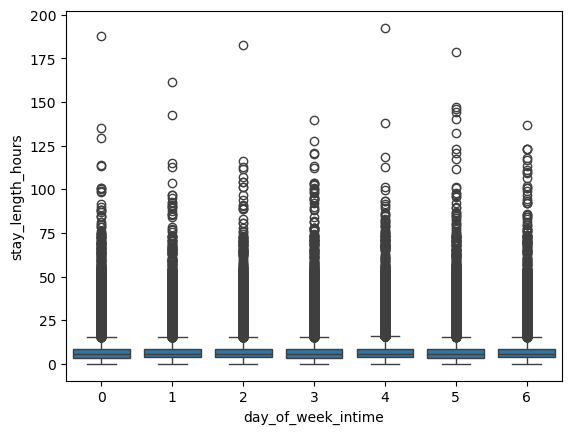

In [8]:
#Looking at stay length, grouped by day of the week for intime. It does not appear that there is any connection, looking at the summary measures.

sns.boxplot(x='day_of_week_intime',y='stay_length_hours', data=df)
df.groupby('day_of_week_intime')['stay_length_hours'].describe()


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,200939.0,7.249344,6.372115,0.0,3.696389,5.600000,8.383333,178.666667
M,169261.0,7.240234,6.815377,0.0,3.516667,5.450278,8.400000,192.566667


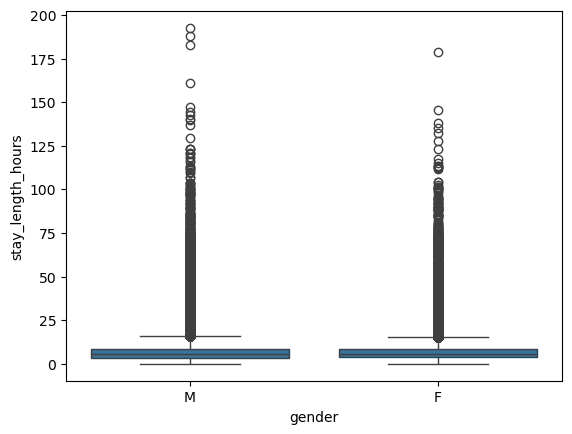

In [9]:
#Looking at stay length, grouped by gender. 

sns.boxplot(x='gender',y='stay_length_hours', data=df)
df.groupby('gender')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
AMERICAN INDIAN/ALASKA NATIVE,917.0,7.725254,7.905772,0.050000,3.700000,5.583333,8.516667,81.916667
ASIAN,6443.0,6.431651,6.268804,0.083333,3.116667,4.850000,7.400000,123.133333
ASIAN - ASIAN INDIAN,1356.0,6.535657,5.895348,0.000000,3.179167,5.016667,7.604167,58.950000
ASIAN - CHINESE,6517.0,6.871851,5.775337,0.016667,3.550000,5.416667,8.100000,75.583333
ASIAN - KOREAN,706.0,6.022873,5.333504,0.066667,3.033333,4.716667,7.195833,62.766667
ASIAN - SOUTH EAST ASIAN,1365.0,7.162864,5.902574,0.116667,3.716667,5.466667,8.366667,52.566667
BLACK/AFRICAN,4249.0,7.270806,6.915779,0.050000,3.433333,5.333333,8.383333,117.200000
BLACK/AFRICAN AMERICAN,66037.0,7.421318,7.024135,0.000000,3.600000,5.583333,8.600000,188.100000
BLACK/CAPE VERDEAN,6711.0,6.541456,5.316736,0.116667,3.466667,5.233333,7.716667,77.050000


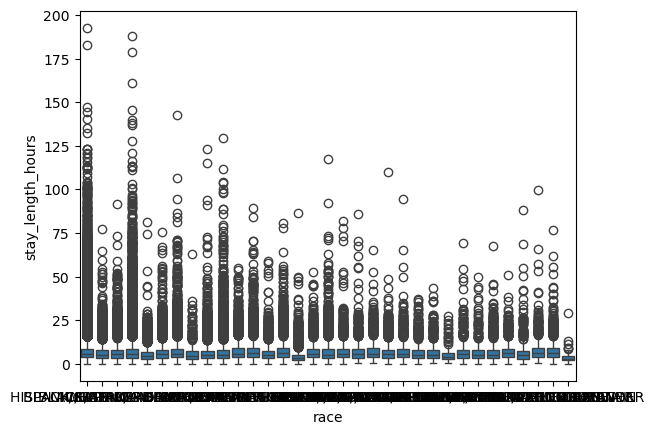

In [10]:
#Looking at stay length, grouped by race. There does seem to be substantial variation across racial categories, 
# but it does not line up nicely with the hierarchy of the categories. For example, note that stay lengths are shorter, generally for "Hispanic or Latino" 
#compareed to the various 'Hispanic/Latino' subcategories.
sns.boxplot(x='race',y='stay_length_hours', data=df)
df.groupby('race')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
race_condensed,,,,,,,,
AMERICAN INDIAN/ALASKA NATIVE,917.0,7.725254,7.905772,0.050000,3.700000,5.583333,8.516667,81.916667
ASIAN,16387.0,6.658619,5.982431,0.000000,3.303056,5.133333,7.783333,123.133333
BLACK,80243.0,7.341927,6.857728,0.000000,3.583333,5.550000,8.533333,188.100000
HISPANIC/LATINO,29893.0,7.077610,6.218265,0.000000,3.583333,5.483333,8.266667,142.766667
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,444.0,6.855886,6.330782,0.033333,3.376458,5.050000,7.812500,49.816667
OTHER,18473.0,6.740310,6.369545,0.000000,3.333333,5.133333,7.750000,129.400000
White,215753.0,7.400722,6.608291,0.000000,3.733333,5.666667,8.533333,192.566667


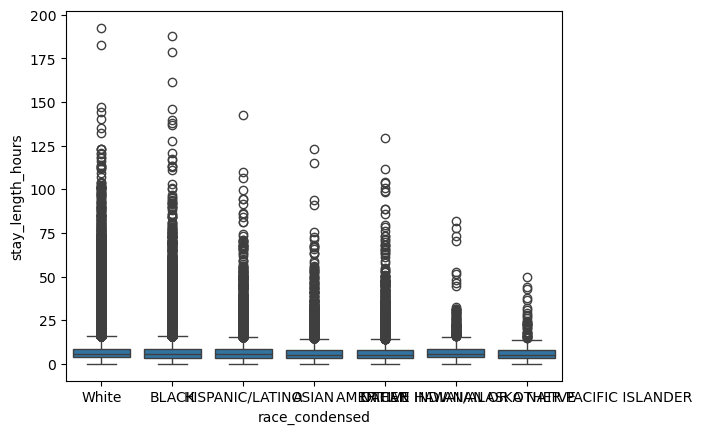

In [21]:
sns.boxplot(x='race_condensed',y='stay_length_hours', data=df)
df.groupby('race_condensed')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
arrival_transport,,,,,,,,
AMBULANCE,137975.0,8.359990,7.329727,0.000000,4.283333,6.350000,9.616667,161.283333
HELICOPTER,780.0,4.660233,3.514314,0.200000,2.562500,3.825000,5.650000,29.700000
OTHER,1113.0,8.108707,10.154655,0.417222,3.316667,5.439722,8.550000,188.100000
UNKNOWN,8368.0,3.740110,3.418649,0.000000,1.723889,3.166667,4.966667,79.100000
WALK IN,221964.0,6.689095,6.017449,0.000000,3.350000,5.166667,7.783333,192.566667


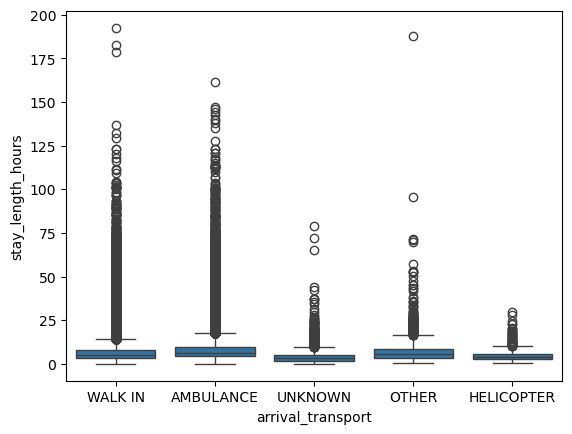

In [11]:
#Looking at stay length, grouped by arrival transport. There are significant differences here.
sns.boxplot(x='arrival_transport',y='stay_length_hours', data=df)
df.groupby('arrival_transport')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
acuity,,,,,,,,
1.0,21420.0,6.064882,4.956279,0.0,3.333333,4.883333,7.144375,111.666667
2.0,122959.0,8.629886,7.888334,0.0,4.351944,6.400000,9.666667,192.566667
3.0,194345.0,7.073043,5.875938,0.0,3.716667,5.566667,8.283333,182.605556
4.0,24387.0,3.527073,3.538230,0.0,1.866667,2.750000,4.049583,113.016667
5.0,906.0,2.418038,2.900365,0.0,1.016667,1.833333,2.816667,36.716667


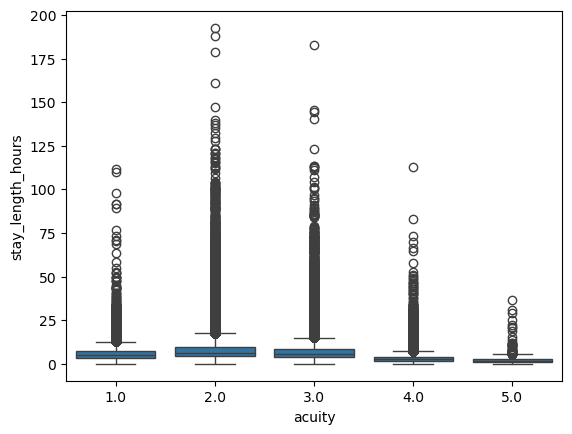

In [12]:
#Acuity is a ranking by a registered nurse based on the Emergency Severity Index (ESI). See details here: https://mimic.mit.edu/docs/iv/modules/ed/triage/ 
#It looks like this has a reasonably strong (but not monotonic) relationship.
sns.boxplot(x='acuity',y='stay_length_hours', data=df)
df.groupby('acuity')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
pain,,,,,,,,
6-9,1.0,7.433333,NaN,7.433333,7.433333,7.433333,7.433333,7.433333
0,9.0,8.328642,7.345726,2.094167,5.000000,5.350000,8.233333,25.866667
10,3.0,5.855556,1.879741,4.600000,4.775000,4.950000,6.483333,8.016667
4,1.0,5.383333,NaN,5.383333,5.383333,5.383333,5.383333,5.383333
6,2.0,6.966667,3.252691,4.666667,5.816667,6.966667,8.116667,9.266667
...,...,...,...,...,...,...,...,...
yelling,1.0,5.831944,NaN,5.831944,5.831944,5.831944,5.831944,5.831944
yes,96.0,8.222274,5.733860,0.833333,4.300069,6.975000,9.662500,29.366667
yes,1.0,11.733333,NaN,11.733333,11.733333,11.733333,11.733333,11.733333


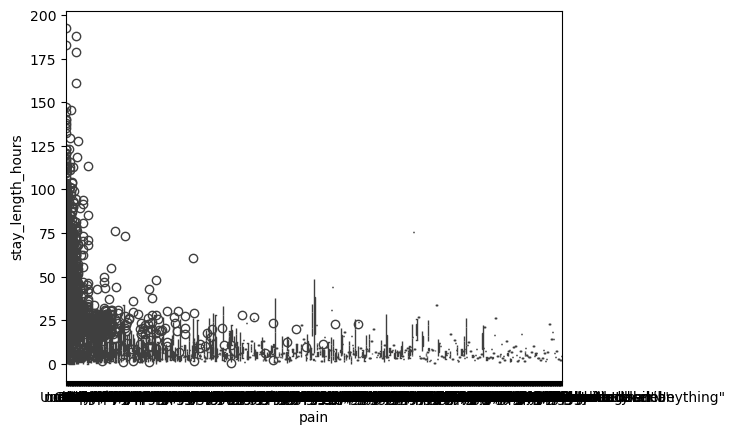

In [13]:
sns.boxplot(x='pain',y='stay_length_hours', data=df)
df.groupby('pain')['stay_length_hours'].describe()

<Axes: xlabel='temperature', ylabel='stay_length_hours'>

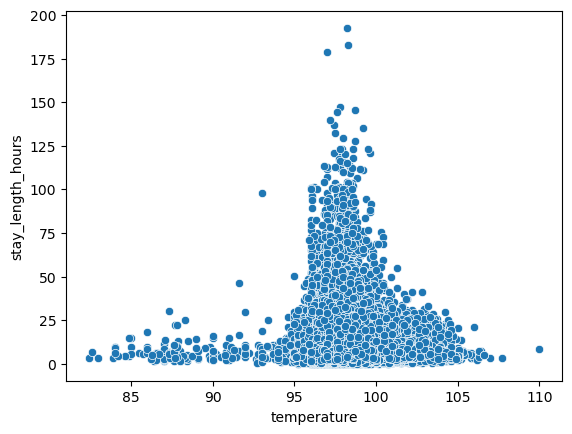

In [14]:
sns.scatterplot(x="temperature",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='heartrate', ylabel='stay_length_hours'>

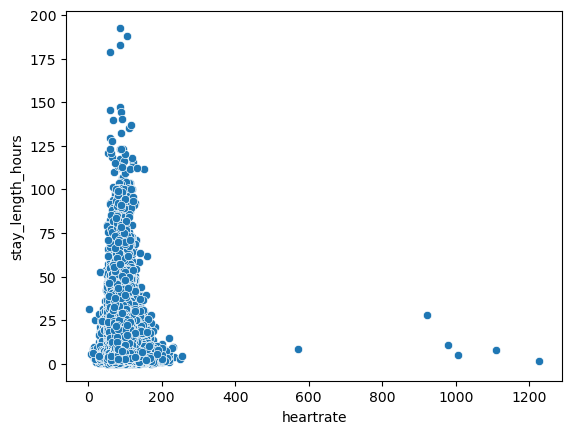

In [15]:
sns.scatterplot(x="heartrate",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='resprate', ylabel='stay_length_hours'>

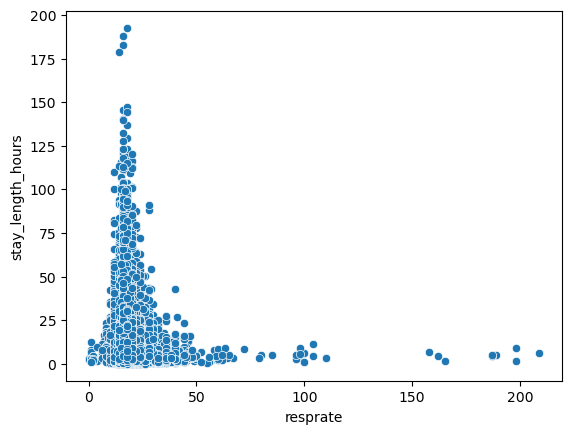

In [16]:
sns.scatterplot(x="resprate",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='o2sat', ylabel='stay_length_hours'>

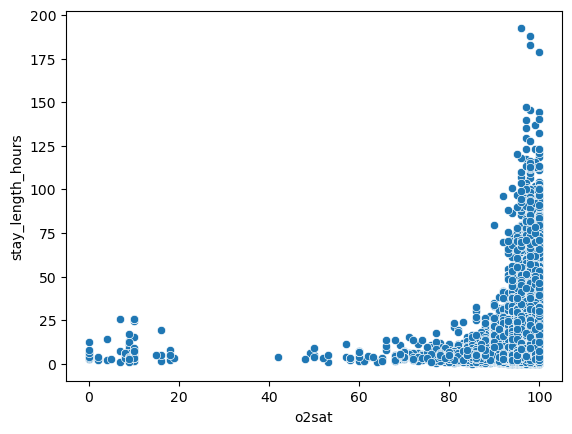

In [17]:
sns.scatterplot(x="o2sat",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='sbp', ylabel='stay_length_hours'>

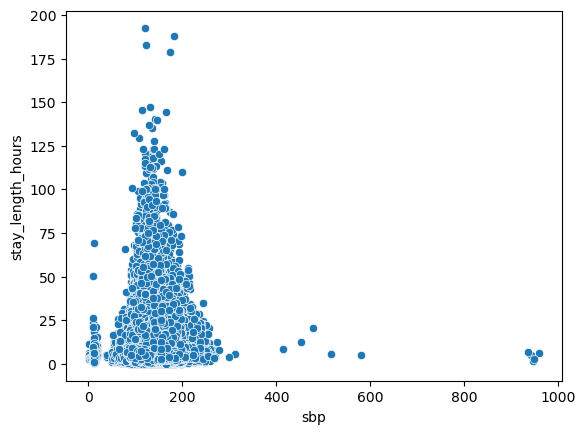

In [18]:
sns.scatterplot(x="sbp",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='dbp', ylabel='stay_length_hours'>

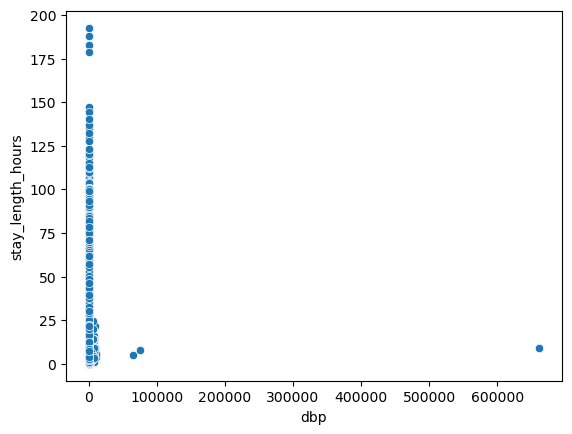

In [19]:
sns.scatterplot(x="dbp",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='pain_cleaned', ylabel='stay_length_hours'>

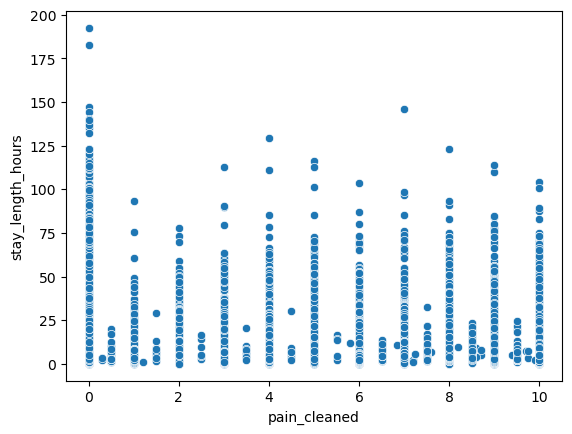

In [20]:
sns.scatterplot(x="pain_cleaned",
                    y="stay_length_hours",
                    data=df)